In [1]:
!pip install dvc dvc[gdrive]

     |████████████████████████████████| 666 kB 6.6 MB/s 
     |████████████████████████████████| 296 kB 60.7 MB/s 
     |████████████████████████████████| 211 kB 34.3 MB/s 
     |████████████████████████████████| 170 kB 59.9 MB/s 
     |████████████████████████████████| 44 kB 3.2 MB/s 
     |████████████████████████████████| 4.6 MB 41.2 MB/s 
     |████████████████████████████████| 530 kB 47.3 MB/s 
     |████████████████████████████████| 109 kB 57.5 MB/s 
     |████████████████████████████████| 40 kB 17 kB/s 
     |████████████████████████████████| 119 kB 68.5 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 1.3 MB 48.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 201 kB 60.0 MB/s 
     |████████████████████████████████| 2.6 MB 42.6 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
     |██████████████████████

In [58]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['agg.path.chunksize'] = 10000
print(tf.__version__)

2.6.0


In [2]:
# Data Version Control
import os
import dvc.api
from io import StringIO,BytesIO

# Your dependencies ... 
import pandas as pd

In [3]:
def get_dvc_file(file_path: str, github_tag='v1.1_Gdrive_remote', 
                 pat_path='.github_pat', repo='Explore-AI/EXPLORE.Utilities.Epl.Core.git'):
  """Utility function to convert a file path into DVC-based
     file stream for the underlying data. 

    Args:
        file_path (str): Path to the data file. Should be relative to the 
                         base of the Git repository. 
        github_tag (str): The GitHub tag associated with the version 
                          of the data being used.
        pat_path (str): Path to a file containing your GitHub personal
                        access token (PAT).
        repo (str): The GitHub repo associated with DVC where the data is 
                    being tracked. 
  """
  # Retrieve GitHub secrets file
  try:
    with open(pat_path, "r") as f: 
      pat_secret = f.readline()
  except: 
    raise FileNotFoundError(f"The given path to your GitHub PAT file: '{pat_path}', doesn't exist")
  
  # Choose reading method based-on input file type
  file_extension = file_path.split('.')[-1]

  if file_extension in ['csv']:
    read_mode = 'r'
    reader = lambda x: StringIO(x)
  else:
    read_mode = 'rb'
    reader = lambda x: BytesIO(x)

  file_stream = dvc.api.read(
      path=file_path,
      repo=f'https://{pat_secret}@github.com/{repo}',
      rev=github_tag,
      mode=read_mode
  )
  file_stream = reader(file_stream)
  return file_stream

In [29]:
#Filtered raw data
#raw_filtered = pd.read_csv(get_dvc_file('enrich/water/synthetic_data/validation/data/filtered_raw.csv','v1.3_raw_filter_data'))

raw_filtered = pd.read_csv(get_dvc_file('enrich/water/synthetic_data/validation/data/filtered_raw.csv','v1.3_raw_filter_data'), parse_dates=['timestamp'])
raw_filtered.set_index('timestamp', inplace=True)
raw_filtered.head()

,tag_name,value
timestamp,,
2021-05-31 23:45:00+00:00,DLM:14336-FLOW,30.410847
2021-06-01 00:00:00+00:00,DLM:14336-FLOW,29.162193
2021-06-01 00:15:00+00:00,DLM:14336-FLOW,28.678840
2021-06-01 00:30:00+00:00,DLM:14336-FLOW,27.416758
2021-06-01 00:45:00+00:00,DLM:14336-FLOW,26.906553


In [43]:
raw_filtered.isnull().sum()

tag_name         0
value       130167
dtype: int64

In [44]:
def fill_empty(df, column):
    """
    This function replaces empty and null values using the forward fill method
    """
    changed = df[column].isnull().sum()
    df[column].fillna((df[column].mean()), inplace=True)
    
    return 'Number of entries filled: '+str(changed)

In [45]:
fill_empty(raw_filtered, 'value')

'Number of entries filled: 130167'

In [13]:
raw_filtered.isnull().sum()

timestamp    0
tag_name     0
value        0
dtype: int64

In [14]:
raw_filtered.head()

,timestamp,tag_name,value
0,2021-05-31T23:45:00.000Z,DLM:14336-FLOW,30.410847
1,2021-06-01T00:00:00.000Z,DLM:14336-FLOW,29.162193
2,2021-06-01T00:15:00.000Z,DLM:14336-FLOW,28.678840
3,2021-06-01T00:30:00.000Z,DLM:14336-FLOW,27.416758
4,2021-06-01T00:45:00.000Z,DLM:14336-FLOW,26.906553


In [15]:
raw_filtered.set_index('timestamp', inplace=True)

In [16]:
raw_filtered.head()

,tag_name,value
timestamp,,
2021-05-31T23:45:00.000Z,DLM:14336-FLOW,30.410847
2021-06-01T00:00:00.000Z,DLM:14336-FLOW,29.162193
2021-06-01T00:15:00.000Z,DLM:14336-FLOW,28.678840
2021-06-01T00:30:00.000Z,DLM:14336-FLOW,27.416758
2021-06-01T00:45:00.000Z,DLM:14336-FLOW,26.906553


In [52]:
raw_filtered.describe()

,value
count,2.525889e+06
mean,1.220961e+01
std,1.970281e+01
min,-1.425432e+02
25%,3.000000e-01
50%,5.729991e+00
75%,1.735883e+01
max,2.821402e+02


Looking at feature values

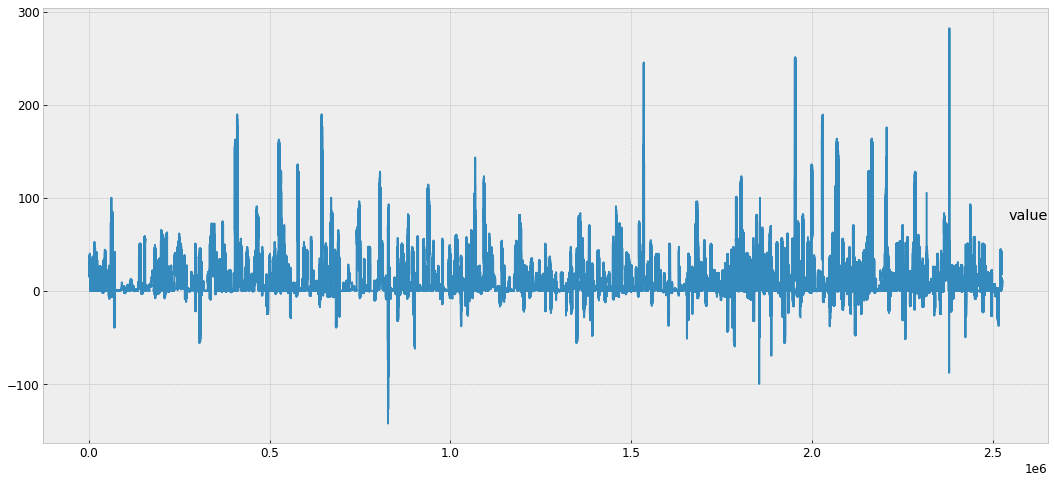

In [35]:
values = raw_filtered.values
groups = [1]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(raw_filtered.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

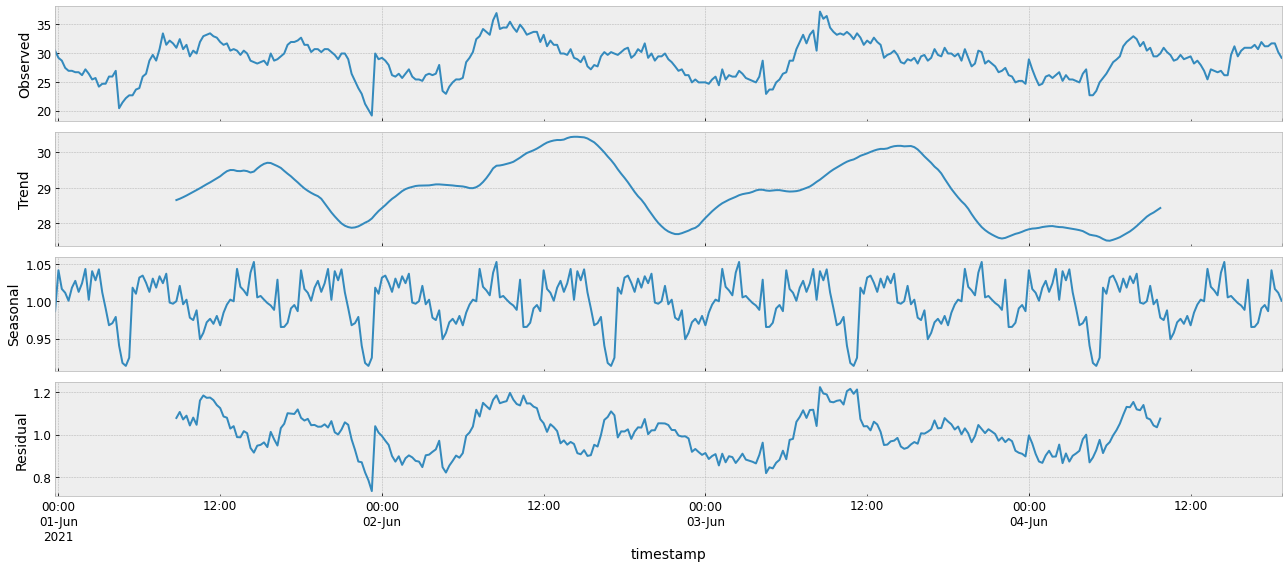

<Figure size 4000x1600 with 0 Axes>

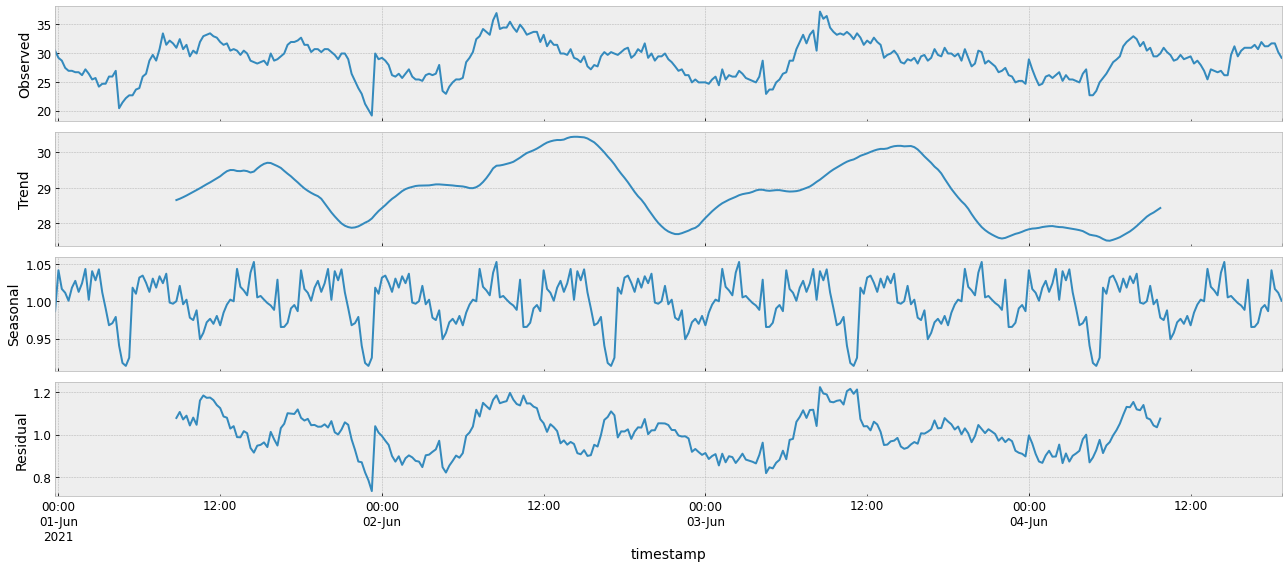

In [56]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = raw_filtered.value[:365]
decompfreq = 6*12
result = seasonal_decompose(series, model='multiplicative',freq=decompfreq)
result.plot()

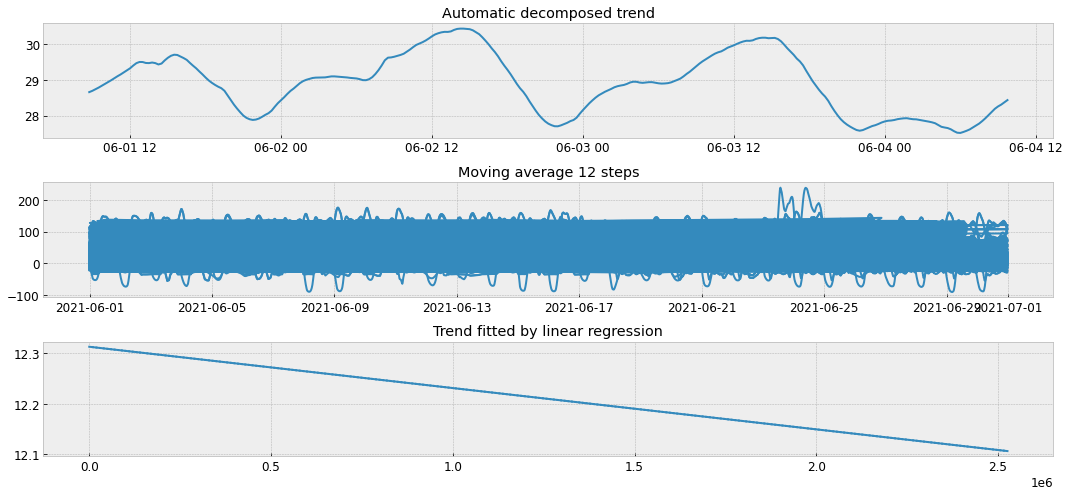

In [59]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = raw_filtered.value.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(raw_filtered.value))]
X = np.reshape(X, (len(X), 1))
y = raw_filtered.value.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

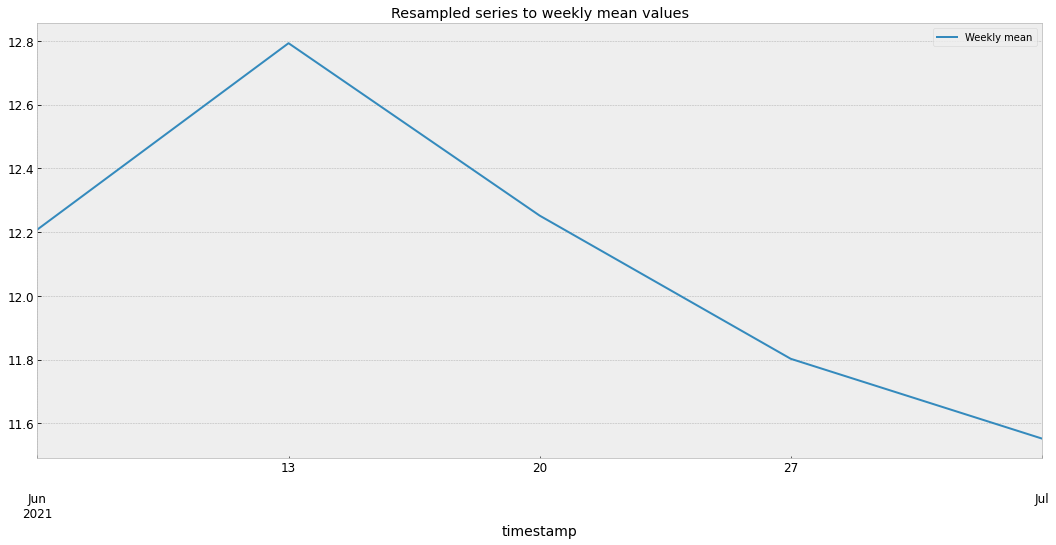

In [60]:
# Looking for weekly seasonality
resample = raw_filtered.resample('W')
weekly_mean = resample.mean()
weekly_mean.value.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

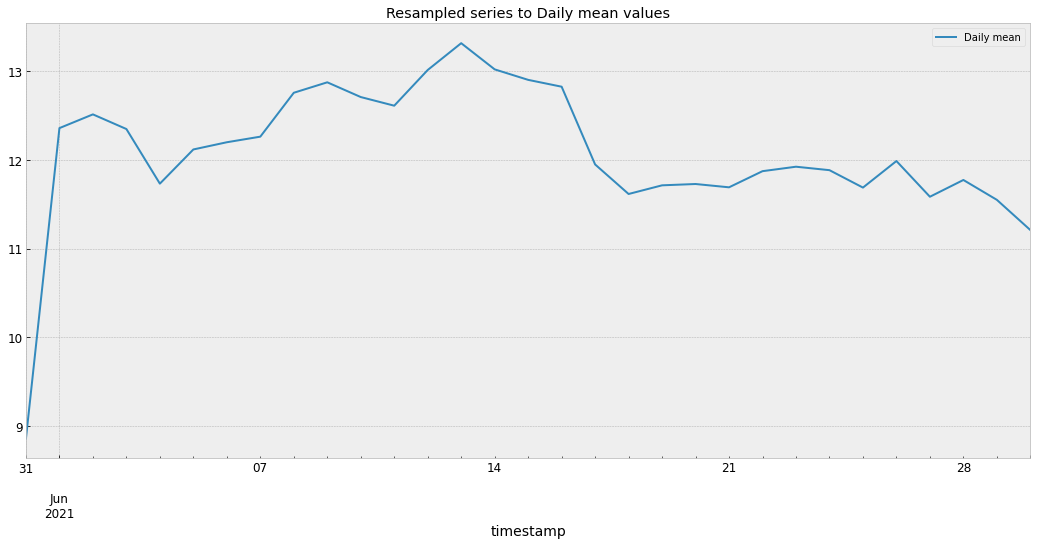

In [61]:
# Looking for Daily seasonality
resample = raw_filtered.resample('D')
daily_mean = resample.mean()
daily_mean.value.plot(label='Daily mean')
plt.title("Resampled series to Daily mean values")
plt.legend()

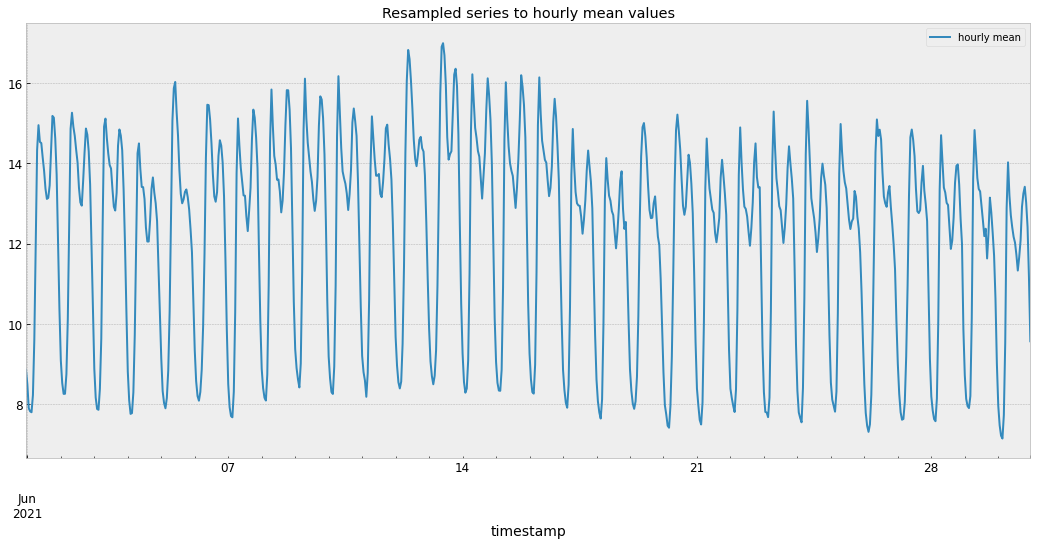

In [62]:
# Looking for hourly seasonality
resample = raw_filtered.resample('H')
hour_mean = resample.mean()
hour_mean.value.plot(label='hourly mean')
plt.title("Resampled series to hourly mean values")
plt.legend()

# Seasonality

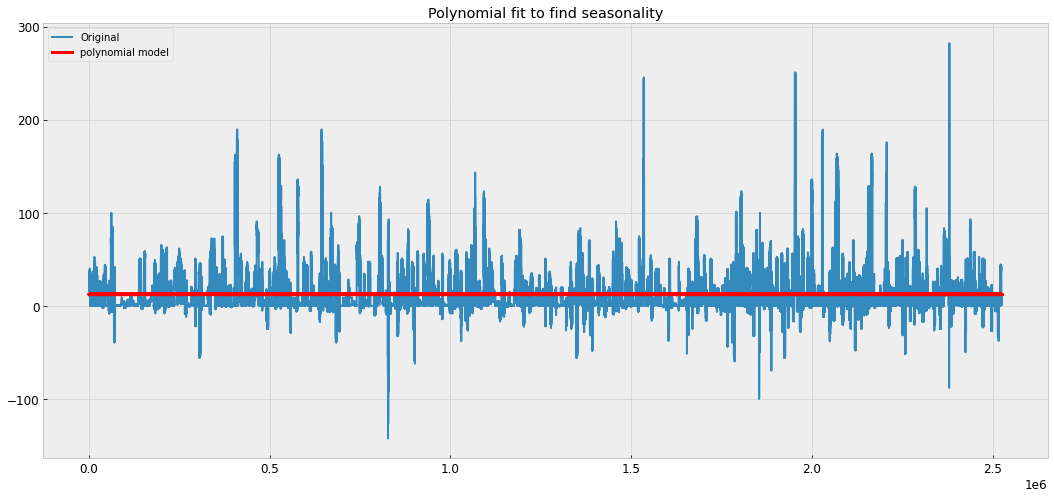

In [63]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = raw_filtered.value.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

# Noise

Text(0.5, 1.0, 'Mean over time')

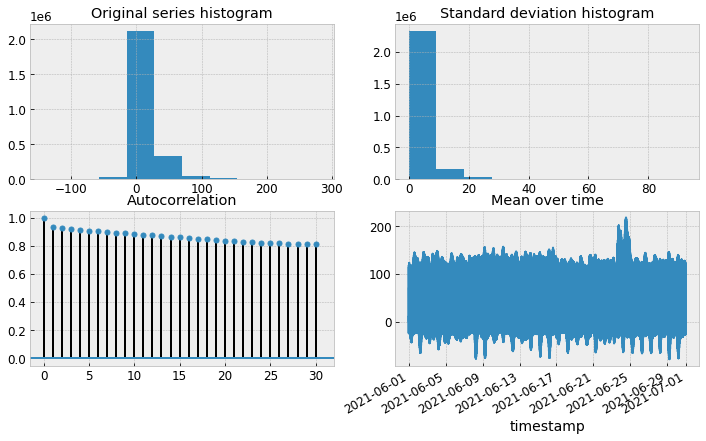

In [65]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

raw_filtered.value.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = raw_filtered.value.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = raw_filtered.value.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")


# Stationarity

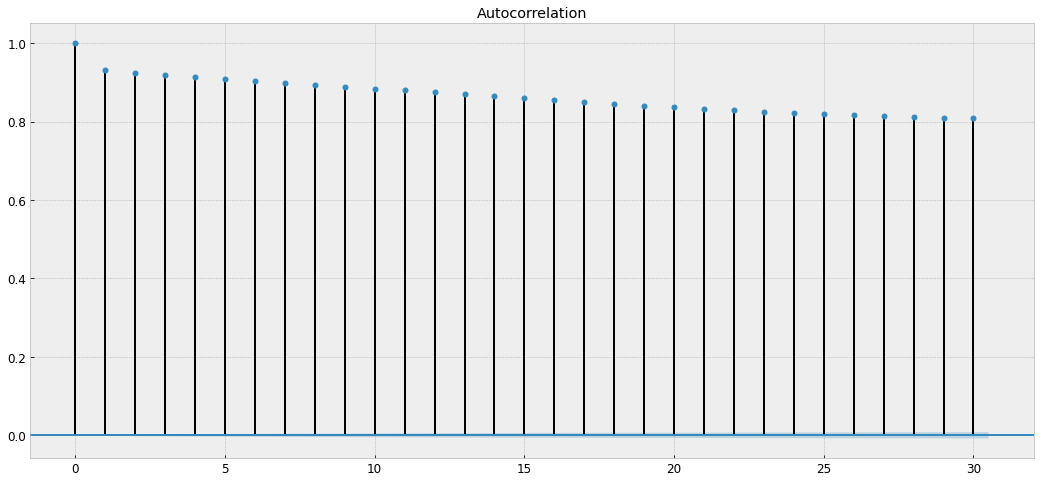

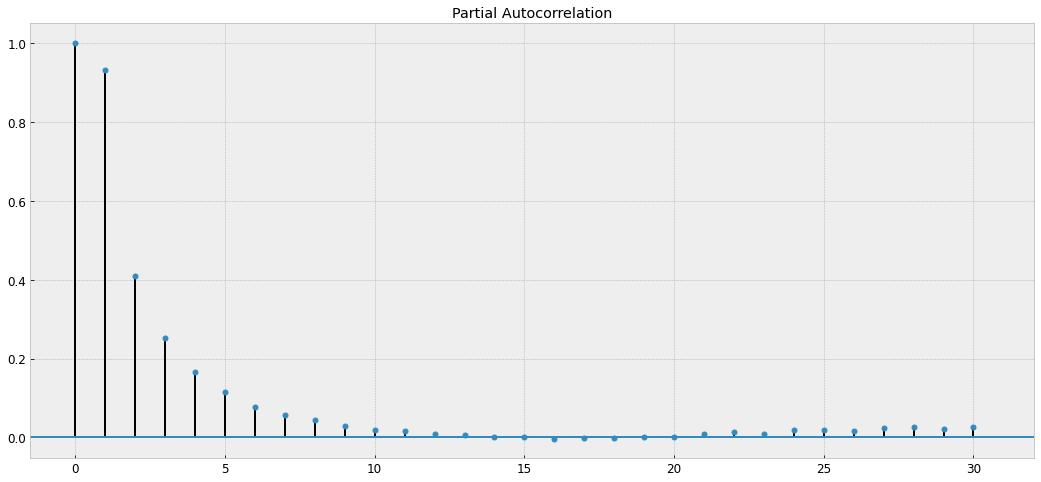

In [66]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()